In [1]:
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchio as tio

from torch.utils.data import DataLoader

from scripts.data import VendorDataset
from scripts.utils.memory import get_total_memory
from scripts.utils.visualization import *
from scripts.load_data import *
from scripts.train import *
from scripts.extract_ROI import extract_ROI 
from scripts.analysis import *
from scripts.preprocessing import split_training_data




seed = 42
random.seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(True, warn_only=True)

plt.rcParams['figure.figsize'] = 12, 6

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
print('Device:', device)

/home/ids/mahdi-22/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run on Thu Jul 20 11:19:54 2023
TorchIO version: 0.18.92
Device: cuda


# Data Loading and Visualization

In [2]:
metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")

In [3]:
padding_size = 10
crop_size = 128

In [52]:
transform = tio.RandomFlip(1, 0.5)
dataset = VendorDataset("A", metadata, augmentation_transform=transform)

train_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=8)

0it [00:00, ?it/s]

317it [00:02, 137.86it/s]


In [9]:
# data_dir = "Data_original/OpenDataset/Training/Labeled/"
# destination_dir = "Data/M&Ms/OpenDataset/Labeled/"
# extract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size ,padding_size=padding_size)

In [10]:
# data_dir = "Data_original/OpenDataset/Testing/"
# destination_dir = "Data/M&Ms/OpenDataset/Testing/"
# extract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size ,padding_size=padding_size)

In [11]:
""" data_dir = "Data_original/OpenDataset/Validation/"
destination_dir = "Data/M&Ms/OpenDataset/Validation/"
extract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size,padding_size=padding_size) """

' data_dir = "Data_original/OpenDataset/Validation/"\ndestination_dir = "Data/M&Ms/OpenDataset/Validation/"\nextract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size,padding_size=padding_size) '

In [3]:
metadata = split_training_data(metadata, train_ratio=0.8)

vendors = list(metadata.Vendor.unique())

transform = tio.RescaleIntensity((0, 1))


total number of samples: 95, train samples: 76, Validation: 19


In [12]:
metadata = split_training_data(metadata, train_ratio=0.8)

vendors = list(metadata.Vendor.unique())

transform = tio.RescaleIntensity((0, 1))


vendor_datasets_3D = []
for vendor in vendors:
    vendor_datasets_3D.append(load_vendor_3D(vendor, metadata, transform))


""" for i in range(4):
    visualize_subject(vendor_datasets_3D[i][0]) """

317it [00:15, 21.13it/s]


Data/M&Ms/OpenDataset/ Dataset size: 76 subjects


317it [00:21, 14.57it/s]


Data/M&Ms/OpenDataset/ Dataset size: 125 subjects


317it [00:03, 88.41it/s] 


Data/M&Ms/OpenDataset/ Dataset size: 19 subjects


317it [00:08, 35.26it/s] 


Data/M&Ms/OpenDataset/ Dataset size: 50 subjects


317it [00:08, 37.88it/s] 

Data/M&Ms/OpenDataset/ Dataset size: 47 subjects


# Train on only one Vendor 

In [64]:
num_epochs = 30
batch_size = 32
num_classes = 4
num_workers = 10
save = True
model_name = "baseline"
save_best=False

model, optimizer, criterion = initialize_model()

model = train_model(model, 
                    optimizer, 
                    criterion,
                    device,  
                    train_dataset, 
                    valid_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    num_epochs=num_epochs,
                    verbose=3,
                    save=save,
                    model_name= model_name,
                    save_best=save_best
                    )

  3%|▎         | 1/30 [00:03<01:30,  3.13s/it]

Epoch [1/30]], Loss: 0.8955, Validation Loss: 1.5130


 37%|███▋      | 11/30 [00:34<00:59,  3.11s/it]

Epoch [11/30]], Loss: 0.0847, Validation Loss: 0.1704


 70%|███████   | 21/30 [01:05<00:28,  3.18s/it]

Epoch [21/30]], Loss: 0.0467, Validation Loss: 0.1677


100%|██████████| 30/30 [01:34<00:00,  3.15s/it]


Stopping Epoch is: 30


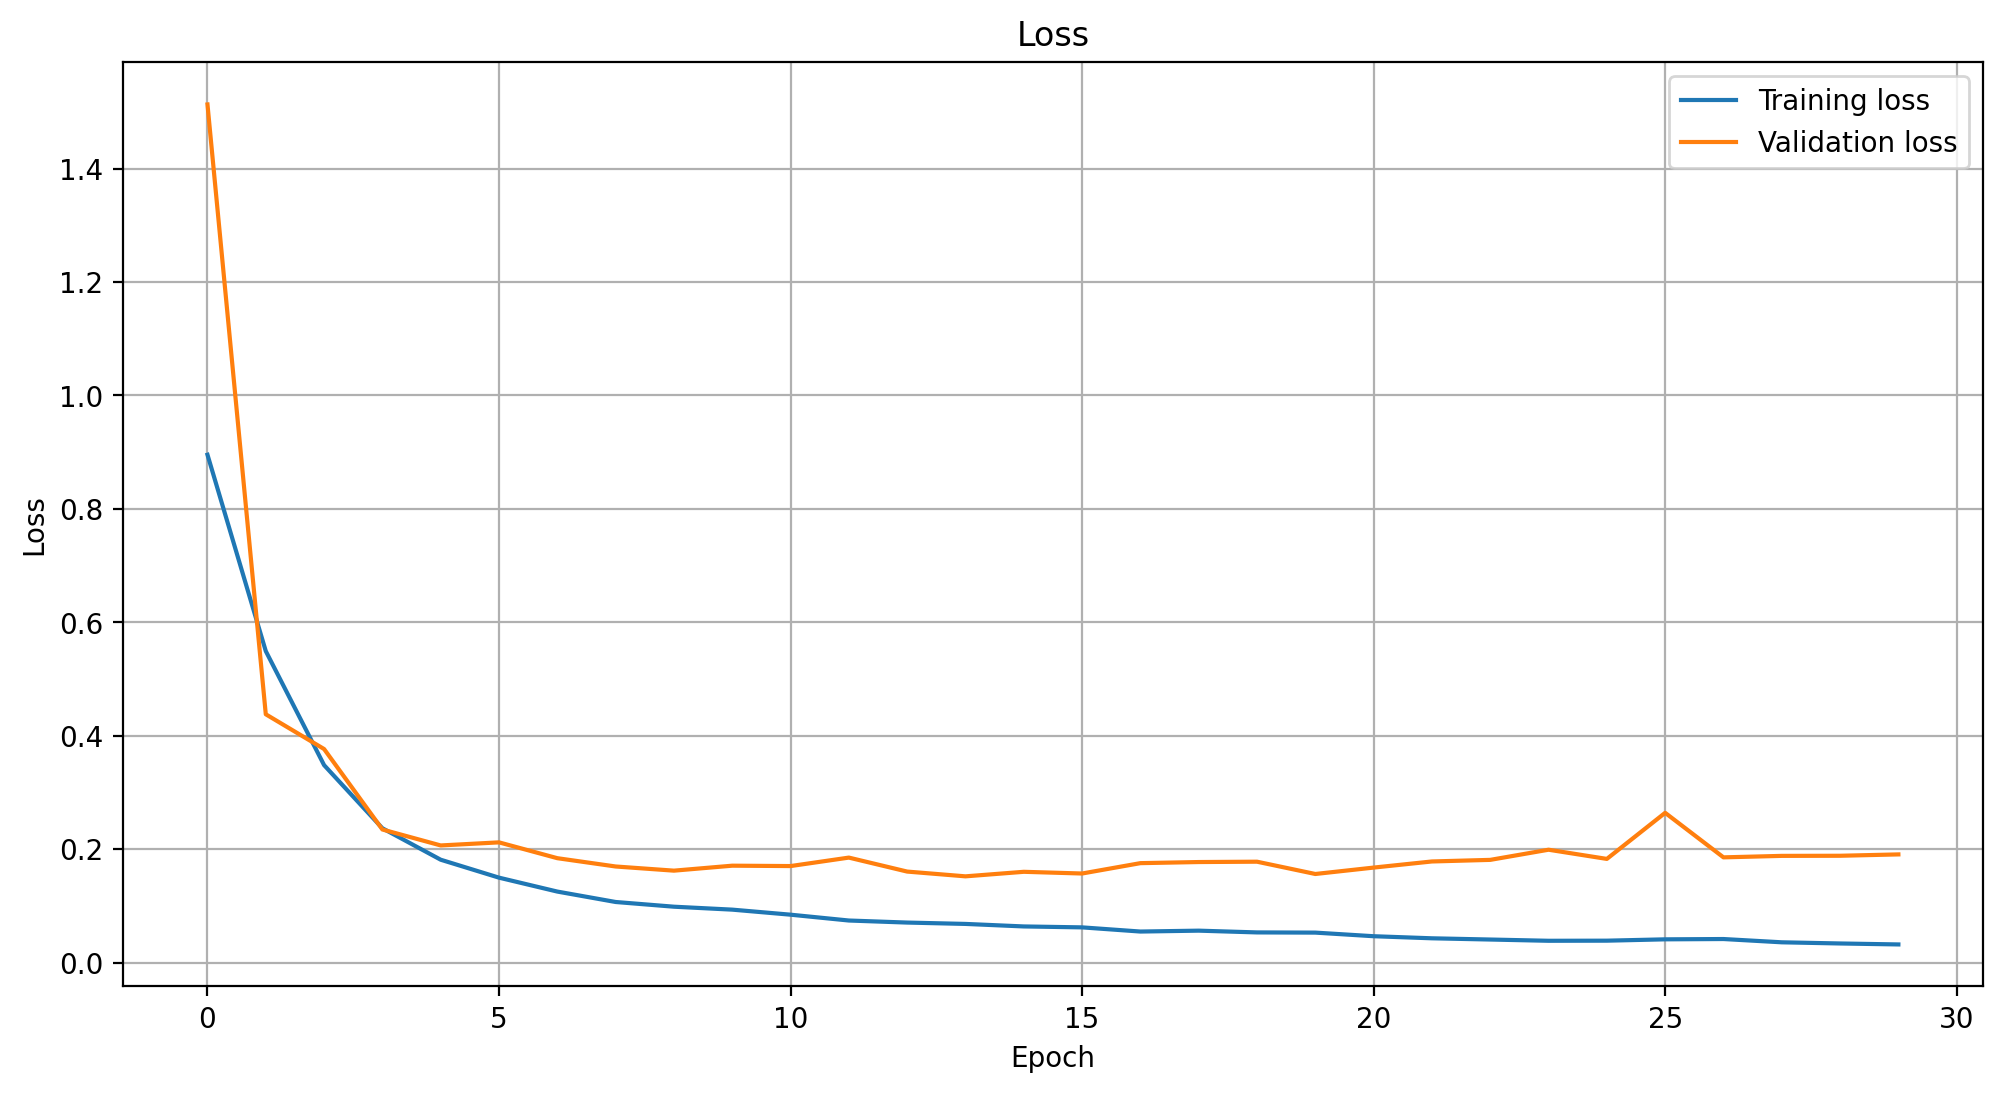

In [65]:
model, optimizer = load_model(model_name, show_performance=True)

In [55]:
""" for i in range(len(vendors)):
    # Get data for one subject
    one_subject = vendor_datasets_3D[i][0]
    visualize_predictions_3D(model, one_subject, device) """

' for i in range(len(vendors)):\n    # Get data for one subject\n    one_subject = vendor_datasets_3D[i][0]\n    visualize_predictions_3D(model, one_subject, device) '

In [82]:
from scripts.pipeline import main_pipeline

In [94]:
main_pipeline("config/config1.toml")

TorchIO version: 0.18.92
Device: cuda
total number of samples: 95, train samples: 76, Validation: 19


317it [00:09, 31.92it/s]
249it [00:02, 78.24it/s] 